In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil

from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import img_to_array, load_img

## 4. Train a convolutional neural network (CNN) with MSE as our loss function - goal is to predict efficiency gaps.

### Model Data Preparation

In [4]:
img_directory = "intermediate\maps"

In [5]:
label = pd.read_csv("input/cnn_target.csv", header=None)
label = label.rename(columns={0: "tag", 1:"eg_swing"})
label.head()

,tag,eg_swing
0,0001_1952_NY,0.03
1,0002_1952_CA,0.05
2,0003_1952_PA,0.04
3,0004_1952_IL,-0.03
4,0005_1952_TX,0.18


#### Data Augmentation

Our first goal is to augment our dataset to increase the dataset size. To do this, we will perform two types of augmentation: flipping, and rotation.

I've refrained from conducting other types of augmentation (shearing, scaling, stretching, [etc.](https://sander.ai/2015/03/17/plankton.html)) as I wanted to preserve spatial relationships between districts (especially the differences between redistricting).

Let's start with a single example - the California plot after the 2011 redistricting.

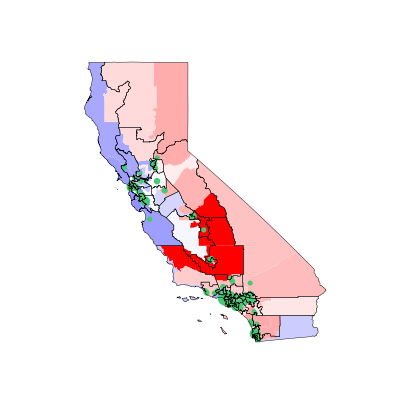

In [5]:
example_img = load_img("intermediate/maps/0306_2012_CA.png")
example_img

In [6]:
example_img_arr = img_to_array(example_img)
example_img_arr = example_img_arr.reshape((1, ) + example_img_arr.shape)

In [21]:
img_gen = keras.preprocessing.image.ImageDataGenerator(rotation_range=180, horizontal_flip=True, vertical_flip=True)

i = 0
for batch in img_gen.flow(example_img_arr, batch_size = 1, save_to_dir ='img', 
                          save_prefix ='ex_augmented_photo', save_format ='png'):
    i += 1
    if i > 3:
        break 

![Image 1](img\ex_augmented_photo_0_3523.png)
![Image 2](img\ex_augmented_photo_0_9682.png)

The example images show the augmentations work as expected.


#### Attaching Labels 

Each label represents the efficiency gap swing after redistricting - **positive scores represent gerrymandered gains for Republicans, and negative scores represent gerrymandered gains for Democrats.**

We are going to use a multiclass classification model to avoid some of the difficulties and problems with CNN architectures for regression (as mentioned [here](https://stats.stackexchange.com/questions/335836/cnn-architectures-for-regression), example by [Fischer et. al., 2015](https://lmb.informatik.uni-freiburg.de/Publications/2015/FDB15/image_orientation.pdf)). Classification will also theoretically provide a larger acceptable margin of error. We do not really care about the specific number, moreso the rough degree to which a party has gerrymandered a district.

We will provide 5 labels:
- (EG-R) "Extreme Gerrymander for Republicans" - swing >= 0.15
- (SG-R) "Slight Gerrymander for Republicans" - 0.05 <= swing < 0.15 
- (NC) "No Change" - -0.05 > swing < 0.05
- (SG-D) "Slight Gerrymander for Democrats" - -0.15 < swing <= -0.05
- (EG-D) "Extreme Gerrymander for Democrats" - -0.15 <= swing



In [6]:
buckets = [-1, -0.15, -0.05, 0.05, 0.15, 1]
buckets_name = ["EG-R", "SG-R", "NC", "SG-D", "EG-D"]

label["class"] = pd.cut(label["eg_swing"], buckets, labels=buckets_name)

In [49]:
label.head()

,tag,eg_swing,class
0,0001_1952_NY,0.03,NC
1,0002_1952_CA,0.05,NC
2,0003_1952_PA,0.04,NC
3,0004_1952_IL,-0.03,NC
4,0005_1952_TX,0.18,EG-D


C:\Users\tobyt\AppData\Local\Temp\ipykernel_34968\605776009.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(labels=buckets_name, rotation=45)


Text(0.5, 1.0, 'Efficiency Gap Swings - Class Spread')

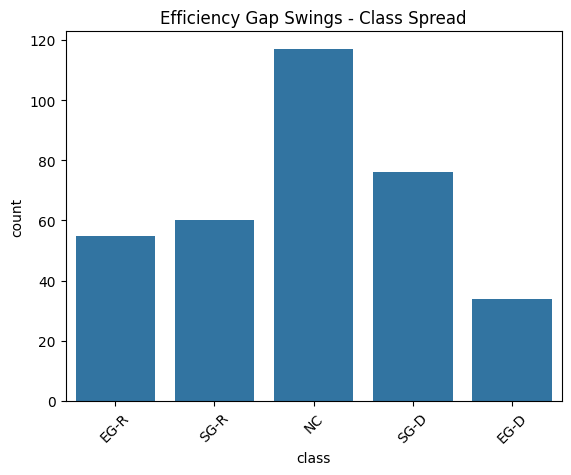

In [7]:
g = sns.countplot(data=label, x="class")
g.set_xticklabels(labels=buckets_name, rotation=45)
g.set_title("Efficiency Gap Swings - Class Spread")

There are **class imbalances** within our data - almost $\frac{1}{3}$ of all maps show no change. 

To correct this, we can correct for class imbalances through various methods (outlined by Buda et. al., 2017 [here](https://arxiv.org/pdf/1710.05381)). 

Undersampling may lead to issues as our dataset is already quite small. We can choose to adjust the class weights for cost-sensitive learning to penalise minority misclassification at a higher level, forcing the model to better adjust for errors in minority classes. 

#### Sorting Maps into Directories

We can sort our training photos into 5 directories using these categories. 

To do so, we need to first split our dataset into training and testing - we will use a 70/30 split given the small size of our dataset.

In [8]:
# Shuffle dataset
label = label.sample(frac=1).reset_index(drop=True)

# Splitting into train/test split
train_split = int(0.7 * label.shape[0])

train_label = label.iloc[:train_split,:]
test_label = label.iloc[train_split:,:]

In [9]:
print(label.shape)
print(train_label.shape)
print(test_label.shape)

(342, 3)
(239, 3)
(103, 3)


In [66]:
# Create 5 directories for training data
for c in buckets_name:
    try:
        os.mkdir(f"input/train_data/{c}")
    except FileExistsError as fe:
        print(f"{c} directory already exists")


In [73]:
# Place train maps into correct directory 
for index, row in train_label.iterrows():
    img_file = row['tag']
    img_class = row['class']
    
    shutil.move(f"intermediate/maps/{img_file}.png", f"input/train_data/{img_class}/{img_file}.png")


In [74]:
# Repeat same process with test data
os.mkdir(f"input/test")

# Create 5 directories for test data
for c in buckets_name:
    try:
        os.mkdir(f"input/test_data/{c}")
    except FileExistsError as fe:
        print(f"{c} directory already exists")

# Place test maps into correct directory 
for index, row in test_label.iterrows():
    img_file = row['tag']
    img_class = row['class']
    
    shutil.move(f"intermediate/maps/{img_file}.png", f"input/test_data/{img_class}/{img_file}.png")


Creating training class weights for cost-sensitive learning

In [10]:
train_class = train_label["class"]
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_class), y=train_class)
class_weights_dict = dict(enumerate(class_weights))

Text(0.5, 1.0, 'Training Class Weights')

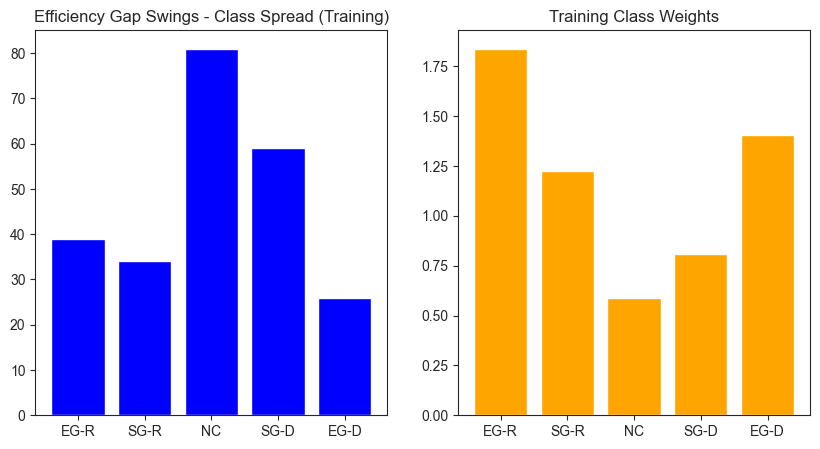

In [105]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].bar(buckets_name, list(train_label.groupby('class').eg_swing.count()), color="blue")
axs[0].set_title("Efficiency Gap Swings - Class Spread (Training)")

axs[1].bar(buckets_name, class_weights_dict.values(), color="orange")
axs[1].set_title("Training Class Weights")

The training class weights are inversely proportional to the number of samples of each class.

### Model Training

#### Initial Model 1

In [19]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(rotation_range=180, horizontal_flip=True, 
                                                             vertical_flip=True, validation_split=0.2)

In [20]:
# Split sets into training and validation

training_set = train_datagen.flow_from_directory("input/train_data", target_size=(400, 400), 
                                                 class_mode = "categorical", subset="training")

validation_set = train_datagen.flow_from_directory("input/train_data", target_size=(400, 400),
                                                 class_mode = "categorical", subset="validation")

Found 194 images belonging to 5 classes.
Found 45 images belonging to 5 classes.


In [189]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=training_set.image_shape),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(5, activation='softmax')  # num_classes should be set to the number of classes
])

model.summary()

c:\Users\tobyt\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 398, 398, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 199, 199, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 197, 197, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 98, 98, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 614656)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │    78,676,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,696,133 (300.20 MB)

 Trainable params: 78,696,133 (300.20 MB)

 Non-trainable params: 0 (0.00 B)

In [190]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'recall', 'precision'])

# Fit the model with class weights
history = model.fit(training_set, epochs=15, batch_size=128, class_weight=class_weights_dict, validation_data=validation_set, verbose=0)

c:\Users\tobyt\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Let's plot the results of our training.

In [11]:
def plot_history(epoch_df):
    fig, ax = plt.subplots(2, 2, figsize=(8,8), tight_layout=True)
    fig.suptitle("Training/Validation Metrics Over Training Epochs")

    # Plot for Accuracy
    ax[0, 0].plot(epoch_df[["accuracy", "val_accuracy"]])
    ax[0, 0].set_title("Accuracy", fontsize=10)
    ax[0, 0].set_xlabel("Epoch")
    ax[0, 0].set_ylabel("Accuracy Score")
    ax[0, 0].set_ylim(0, 1)

    # Plot for Loss
    ax[0, 1].plot(epoch_df[["loss", "val_loss"]])
    ax[0, 1].set_title("Categorical Cross-Entropy Loss", fontsize=10)
    ax[0, 1].set_xlabel("Epoch")
    ax[0, 1].set_ylabel("Categorical Cross-Entropy Loss")

    # Plot for Precision
    ax[1, 0].plot(epoch_df[["precision", "val_precision"]])
    ax[1, 0].set_title("Precision", fontsize=10)
    ax[1, 0].set_xlabel("Epoch")
    ax[1, 0].set_ylabel("Precision Score")
    ax[1, 0].set_ylim(0, 1)


    # Plot for Recall
    ax[1, 1].plot(epoch_df[["recall", "val_recall"]])
    ax[1, 1].set_title("Recall", fontsize=10)
    ax[1, 1].set_xlabel("Epoch")
    ax[1, 1].set_ylabel("Recall Score")
    ax[1, 1].set_ylim(0, 1)


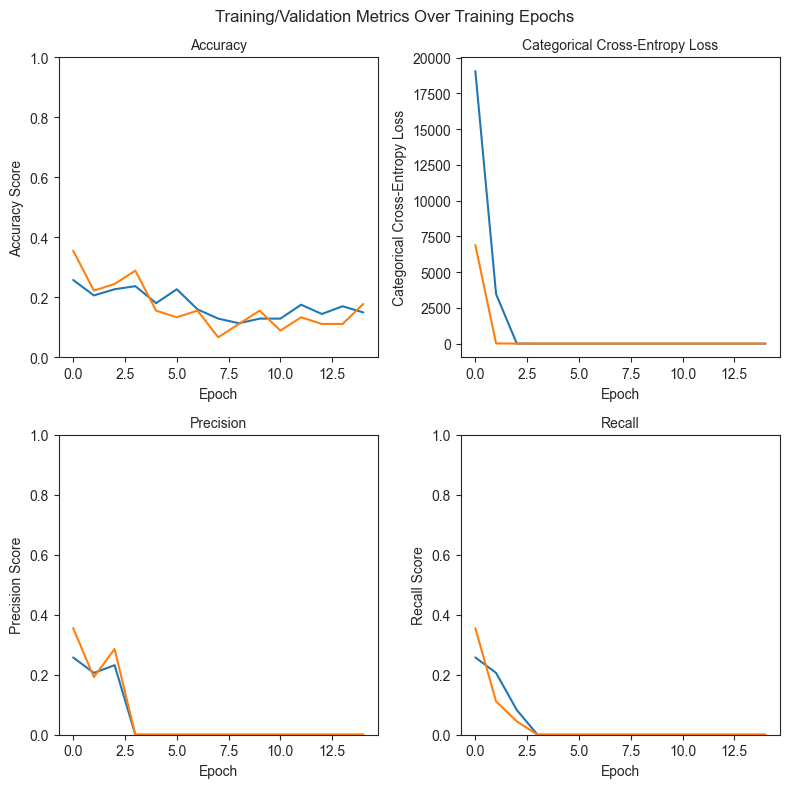

In [191]:
plot_history(pd.DataFrame(history.history))

Terrible at all metrics, essentially randomly guessing.

In [21]:
# Predicting on test data - no image augmentation

test_datagen = keras.preprocessing.image.ImageDataGenerator()

testing_set = train_datagen.flow_from_directory("input/test_data", target_size=(400,400), class_mode="categorical")

Found 103 images belonging to 5 classes.


In [23]:
model_results = pd.DataFrame(columns=["Model", "Loss", "Accuracy", "Precision", "Recall"])

In [24]:
def evaluate_model(res, model_name):
    return {"Model": model_name, "Loss": res[0], "Accuracy": res[1], 
            "Precision": res[2], "Recall": res[3]}

In [25]:
# Load model if necessary (after crashing)
# model = tf.keras.models.load_model('model/initial_model_01.keras')

In [26]:
model_results.loc[len(model_results.index)] = evaluate_model(model.evaluate(testing_set), "initial_model_01")

model_results.head()
                     

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 564ms/step - accuracy: 0.2120 - loss: 1.6178 - precision: 0.0000e+00 - recall: 0.0000e+00


,Model,Loss,Accuracy,Precision,Recall
0,initial_model_01,1.620874,0.23301,0.0,0.0


In [196]:
model.save("model/initial_model_01.keras")

This initial model is clearly terrible - it has an accuracy that's close to guessing at random chance (20%). Let's try to improve the complexity of the model.

#### Initial Model 2

c:\Users\tobyt\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


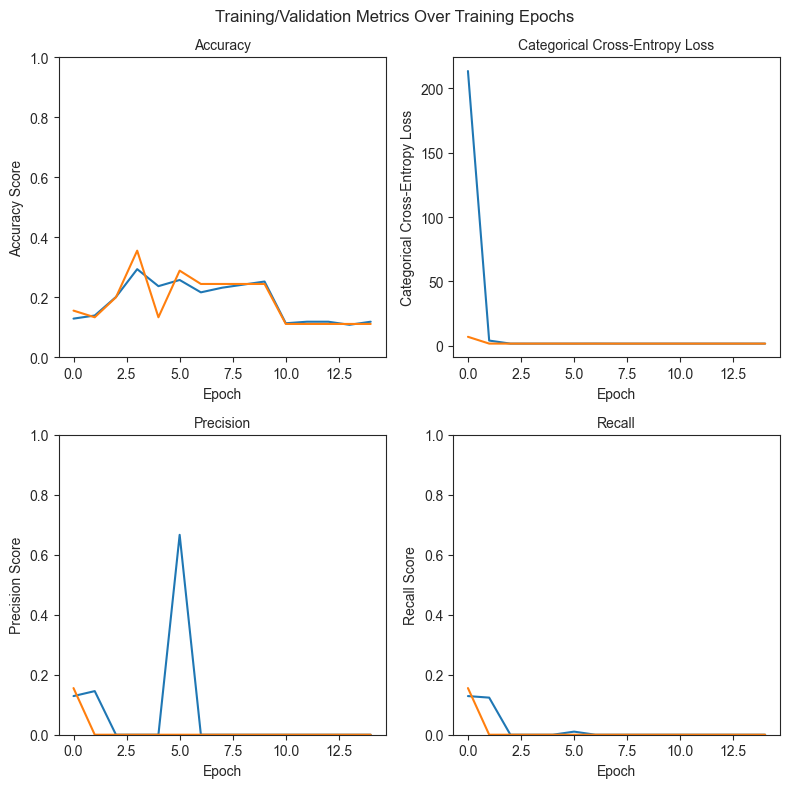

In [197]:
# Increase complexity of model

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', strides=(2, 2), input_shape=training_set.image_shape),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(5, activation='softmax')
])

# Compiling/Fitting Model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'recall', 'precision'])

# Fit the model with class weights
history = model.fit(training_set, epochs=15, batch_size=128, class_weight=class_weights_dict, validation_data=validation_set, verbose=0)

plot_history(pd.DataFrame(history.history))

Our model still lacks the depth required to capture nuances in the model.

The flatlining of accuracy after 10 epochs is interesting - let's see if this trend persists when the number of epochs increase.

In [27]:
# Load model if necessary (after crashing)
# model = tf.keras.models.load_model('model/initial_model_02.keras')

In [28]:
# Add results to dataframe
model_results.loc[len(model_results.index)] = evaluate_model(model.evaluate(testing_set), "initial_model_02")

model_results.sort_values(by="Accuracy", ascending=False)
                     

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 496ms/step - accuracy: 0.0975 - loss: 1.6129 - precision: 0.0000e+00 - recall: 0.0000e+00


,Model,Loss,Accuracy,Precision,Recall
0,initial_model_01,1.620874,0.233010,0.0,0.0
1,initial_model_02,1.612443,0.087379,0.0,0.0


In [200]:
# Save model
model.save("model/initial_model_02.keras")

Doesn't seem to have much effect - let's keep adding layers. We can go to a highly extreme level of complexity and retune it, but the goal is to see if our model is capable of picking up on trends.

I also believe an average pooling is more useful in this case - it can pick up better on the colour differences compared to max.

#### Initial Model 3

In [39]:
# Increase complexity of model

model = Sequential([
    Conv2D(256, (3, 3), activation='relu', input_shape=training_set.image_shape),
    AveragePooling2D((2, 2)),
    Conv2D(512, (3, 3), activation='relu'),
    AveragePooling2D((2, 2)),
    Conv2D(1024, (3, 3), activation='relu'),
    AveragePooling2D((2, 2)),
    Conv2D(2048, (3, 3), activation='relu'),
    AveragePooling2D((2, 2)),
    Flatten(),
    Dense(100, activation='relu'),
    Dense(5, activation='softmax')
])

model.summary()

ResourceExhaustedError: {{function_node __wrapped__StatelessRandomUniformV2_device_/job:localhost/replica:0/task:0/device:CPU:0}} OOM when allocating tensor with shape[2534464,100] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator mklcpu [Op:StatelessRandomUniformV2] name: 

In [18]:
# Compiling/Fitting Model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'recall', 'precision'])

# Fit the model with class weights
history = model.fit(training_set, epochs=30, batch_size=128, class_weight=class_weights_dict, validation_data=validation_set, verbose=0)

plot_history(pd.DataFrame(history.history))

c:\Users\tobyt\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


AbortedError: Graph execution error:

Detected at node StatefulPartitionedCall/sequential_1/conv2d_4_1/Relu defined at (most recent call last):
<stack traces unavailable>
Operation received an exception:Status: 1, message: could not create a memory object, in file tensorflow/core/kernels/mkl/mkl_conv_ops.cc:1112
	 [[{{node StatefulPartitionedCall/sequential_1/conv2d_4_1/Relu}}]] [Op:__inference_one_step_on_iterator_3297]

Note: Introduce dropout if overfitting